In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 0.1,
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

        self.q_table = np.zeros((observation_space, action_space))

    def __call__(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:
        """Return Q-value of given state and action."""
        return self.q_table[state, action]

    def update(self, state: np.ndarray, action: np.ndarray, reward: float, next_state: int) -> None:
        """Update Q-value of given state and action."""
        current_q = self.q_table[state, action]
        best_next_q = np.max(self.q_table[next_state])
        new_q = current_q + self.learning_rate * (reward + self.gamma * best_next_q - current_q)
        self.q_table[state, action] = new_q

    def get_best_action(self, state: np.ndarray) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            best_action = np.argmax(self.q_table[state])
            return best_action.item()  # Dodaj .item() aby uzyskać wartość skalarową

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        return f"QLearningSolver(learning_rate={self.learning_rate}, gamma={self.gamma}, epsilon={self.epsilon})"

    def __str__(self):
        return self.__repr__()

In [23]:
def train(q_solver, env, learning_iter, plots: bool, verbose: bool=False):
    # observation_space = env_handler.observation_space.n
    # action_space = env_handler.action_space.n

    # q_solver = QLearningSolver(observation_space, action_space, q_params[0], q_params[1], q_params[2])

    num_episodes = learning_iter
    all_rewards = []
    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0

        while not done:
            action = q_solver.get_best_action(state)

            next_state, reward, done = env.step(action)[0:3]

            q_solver.update(state, action, reward, next_state)
            total_reward += reward
            state = next_state

        all_rewards.append(total_reward)
        if episode % 10 == 0 and verbose:
            print(f"Episode: {episode}, Total Reward: {total_reward}")
    if plots:
        plt.scatter(all_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total reward')
        plt.show()
    return q_solver

# env = gym.make('Taxi-v3', render_mode='human')
# solver = QLearningSolver(
#     observation_space=env.observation_space.n,
#     action_space=env.action_space.n,
#     learning_rate=0.1,
#     gamma=0.9,
#     epsilon=0.1,
# )

# num_episodes = 1000

# for episode in range(num_episodes):
#     state = env.reset()[0]
#     total_reward = 0

#     while True:
#         action = solver.get_best_action(state)
#         next_state, reward, done = env.step(action)[0:3]

#         solver.update(state, action, reward, next_state)

#         total_reward += reward
#         state = next_state

#         if done:
#             break

#     if episode % 100 == 0:
#         print(f"Episode: {episode}, Total Reward: {total_reward}")

# # Testowanie rozwiązania
# state = env.reset()
# total_reward = 0

# while True:
#     env.render()
#     action = solver.get_best_action(state)
#     next_state, reward, done = env.step(action)[0:3]

#     total_reward += reward
#     state = next_state

#     if done:
#         print(f"Total Reward for Testing: {total_reward}")
#         break

# env.close()


def tester(env_handler, q_solver, testing_iter, plot: bool, verbose: int):
    test_rewards = np.array([])
    episodes_list = [i for i in range(testing_iter)]
    for episode in range(testing_iter):
        state = env_handler.reset()[0]
        done = False
        total_reward = 0
        # prev_state = None
        # prev_state2 = False

        while not done:
            # if prev_state == state or prev_state2 == prev_state:
            #     action = env_handler.action_space.sample()
            # else:
            action = q_solver.get_best_action(state)
            # print(f'stan:{state}; akcja: {action}')
            next_state, reward, done= env_handler.step(action)[0:3]
            total_reward += reward
            # prev_state2 = prev_state
            # prev_state = state
            state = next_state
            env_handler.render()
        test_rewards = np.append(test_rewards, [total_reward])
        if verbose == 2:
            print(f"Episode: {episode}, Total Reward: {total_reward}")
    if verbose == 1:
        print(f'Mean of reward value: {np.mean(test_rewards)}')
    if plot:
        plt.scatter(episodes_list, test_rewards)
        plt.plot(test_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total reward')
        plt.show()
    return np.mean(test_rewards)

Mean of reward value: -0.3333333333333333


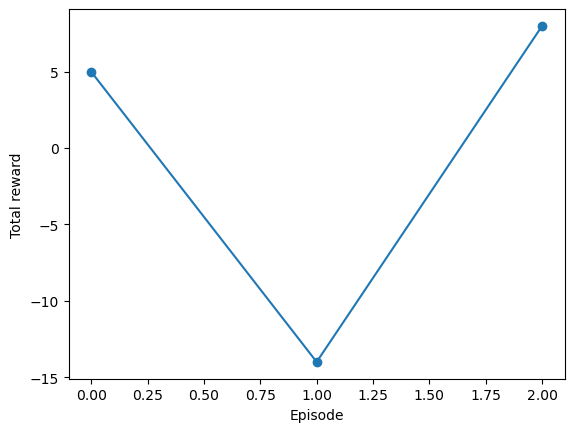

In [6]:
# Visualisation

env = gym.make('Taxi-v3')

solver = QLearningSolver(
    observation_space=env.observation_space.n,
    action_space=env.action_space.n,
)

q_solver = train(solver, env, 2500, False, False)

test_env = gym.make('Taxi-v3',render_mode='human')

tester(test_env, q_solver, 3, True, 0)


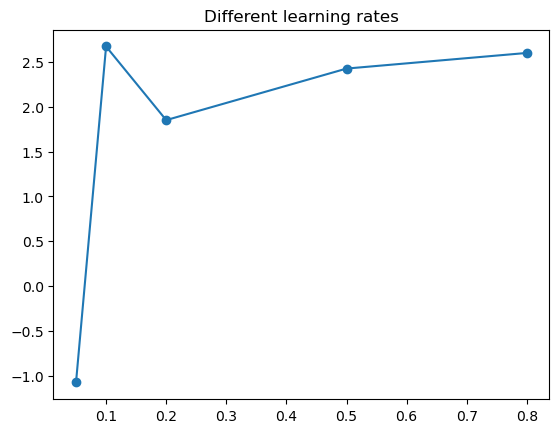

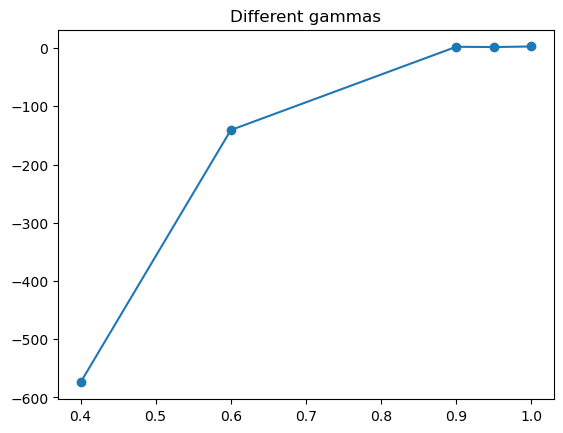

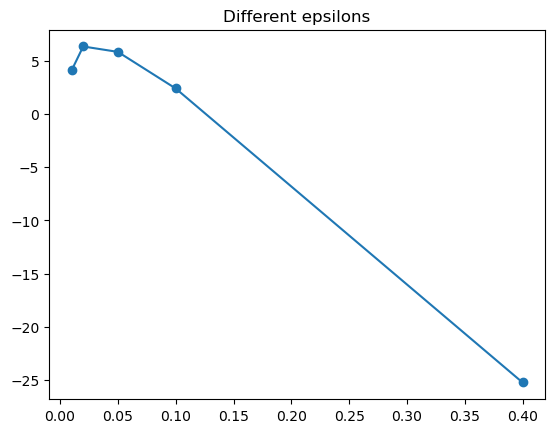

In [24]:
# Tests

learning_rates = [0.05, 0.1, 0.2, 0.5, 0.8]
gammas = [0.4, 0.6, 0.9, 0.95, 1]
epsilons = [0.01, 0.02, 0.05, 0.1, 0.4]
params = [learning_rates, gammas, epsilons]

for param in params:
    mean_rewards = []
    for value in param:
        env = gym.make('Taxi-v3')
        if param == learning_rates:
            solver = QLearningSolver(
                observation_space=env.observation_space.n,
                action_space=env.action_space.n,
                learning_rate = value,
            )
            q_params = [value, 0.9, 0.1]
            title = "Different learning rates"
        elif param == gammas:
            solver = QLearningSolver(
                observation_space=env.observation_space.n,
                action_space=env.action_space.n,
                gamma = value,
            )
            q_params = [0.1, value, 0.1]
            title = "Different gammas"
        elif param == epsilons:
            solver = QLearningSolver(
                observation_space=env.observation_space.n,
                action_space=env.action_space.n,
                epsilon=value
            )
            q_params = [0.1, 0.9, value]
            title = "Different epsilons"

        q_solver = train(solver, env, 5000, False, False)
        # print(f"Learning rate: {q_params[0]}; Gamma: {q_params[1]}; Epsilon: {q_params[2]} \n")
        test_env = gym.make('Taxi-v3', render_mode='ansi')
        mean_rewards.append(tester(test_env, q_solver, 500, False, 0))
    plt.plot(param, mean_rewards)
    plt.scatter(param, mean_rewards)
    plt.title(title)
    plt.show()
